# Few-Shot learning with Reptile

**Author:** [ADMoreau](https://github.com/ADMoreau)<br>
**Date created:** 2020/05/21<br>
**Last modified:** 2023/07/20<br>
**Description:** Few-shot classification on the Omniglot dataset using Reptile.

## Introduction

The [Reptile](https://arxiv.org/abs/1803.02999) algorithm was developed by OpenAI to
perform model-agnostic meta-learning. Specifically, this algorithm was designed to
quickly learn to perform new tasks with minimal training (few-shot learning).
The algorithm works by performing Stochastic Gradient Descent using the
difference between weights trained on a mini-batch of never-seen-before data and the
model weights prior to training over a fixed number of meta-iterations.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow_datasets as tfds

## Define the Hyperparameters

In [3]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

## Prepare the data

The [Omniglot dataset](https://github.com/brendenlake/omniglot/) is a dataset of 1,623
characters taken from 50 different alphabets, with 20 examples for each character.
The 20 samples for each character were drawn online via Amazon's Mechanical Turk. For the
few-shot learning task, `k` samples (or "shots") are drawn randomly from `n` randomly-chosen
classes. These `n` numerical values are used to create a new set of temporary labels to use
to test the model's ability to learn a new task given few examples. In other words, if you
are training on 5 classes, your new class labels will be either 0, 1, 2, 3, or 4.
Omniglot is a great dataset for this task since there are many different classes to draw
from, with a reasonable number of samples for each class.

In [4]:

class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

2025-12-09 00:42:40.106378: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-09 00:42:40.106409: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-09 00:42:40.106420: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-09 00:42:40.106649: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-09 00:42:40.106974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Visualize some examples from the dataset

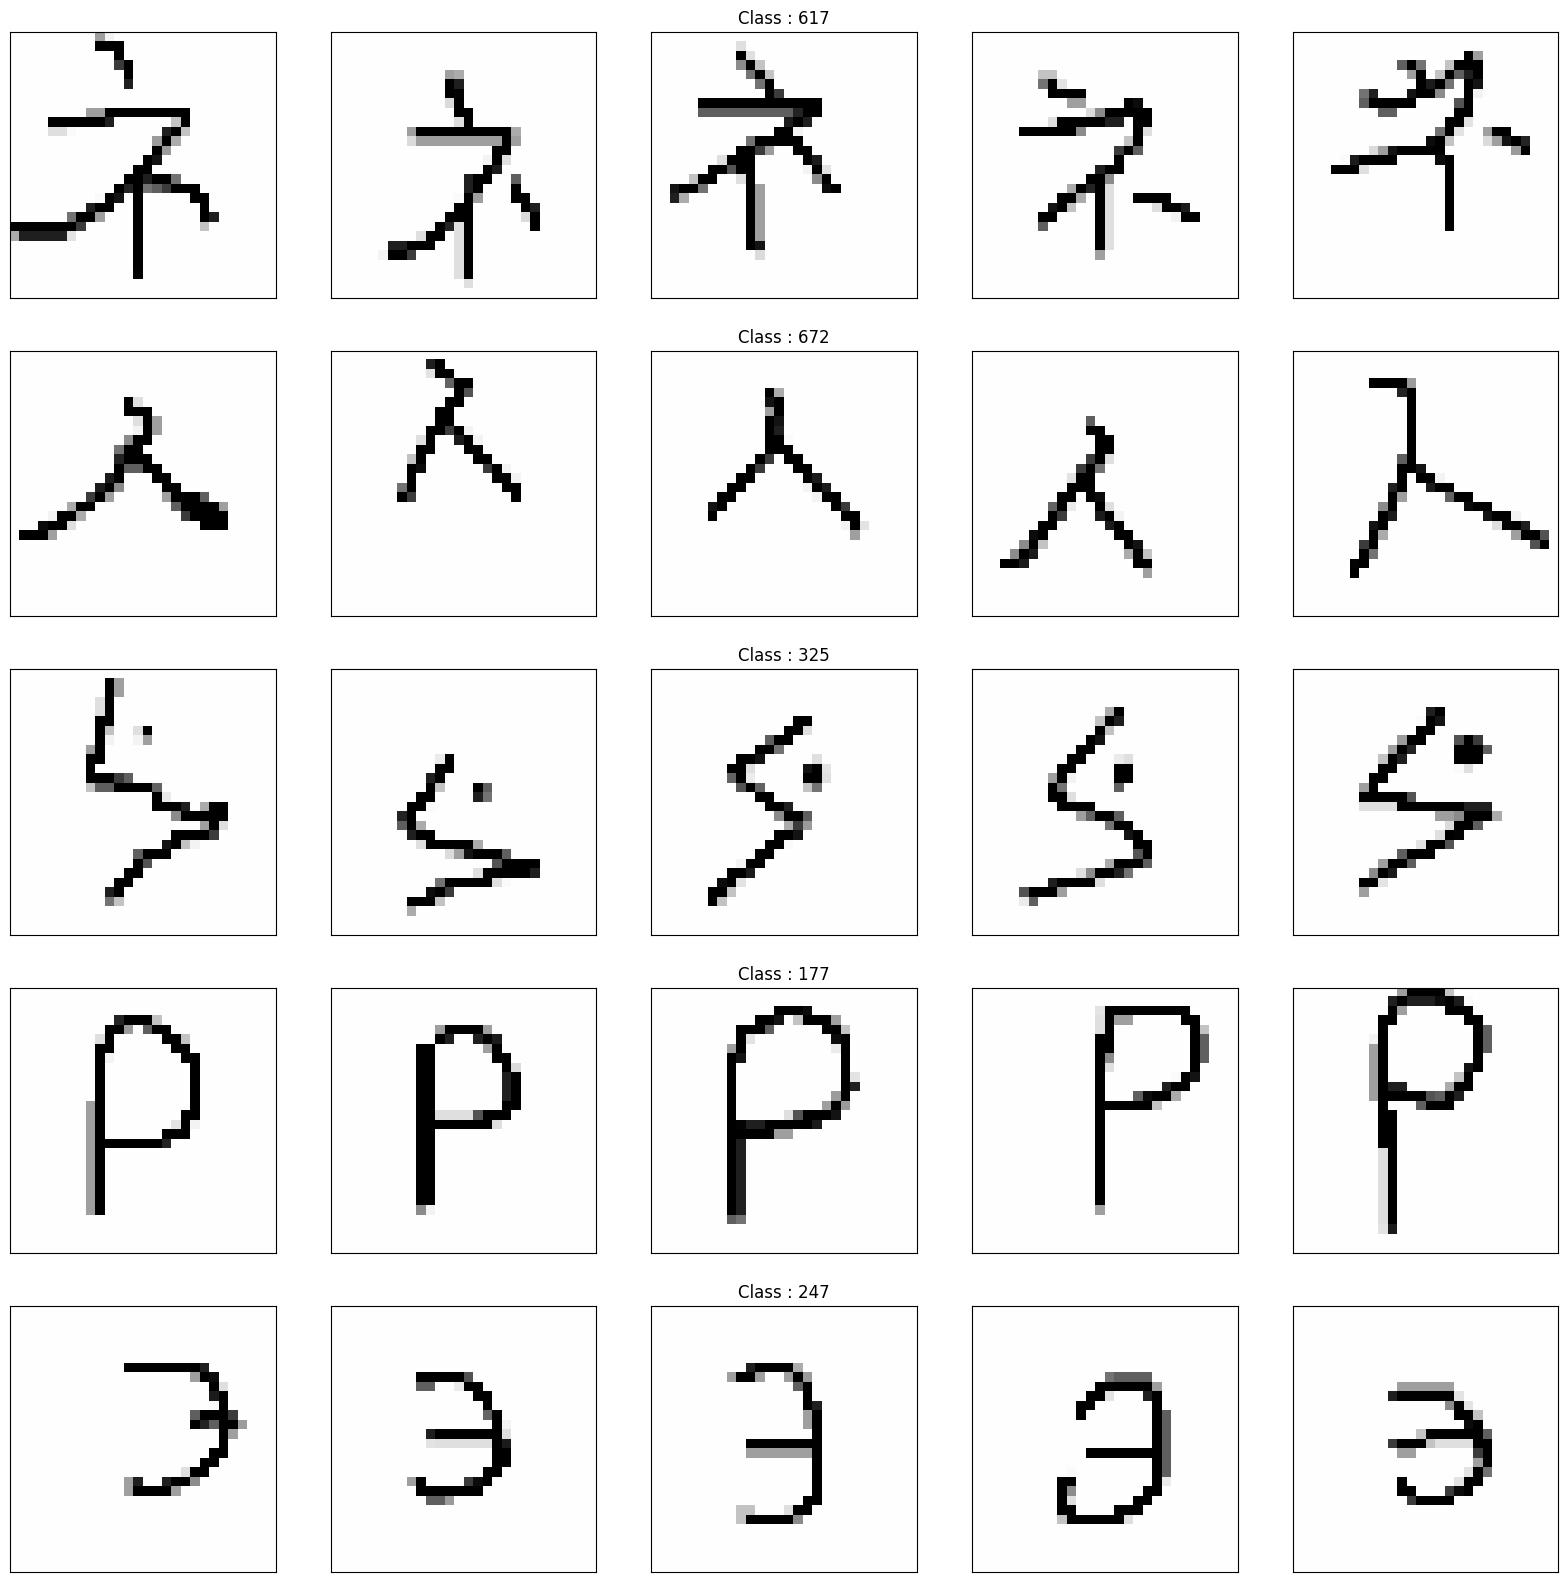

In [5]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

## Build the model

In [6]:

def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

In [7]:
import tensorflow as tf
import keras

print("=== 1. 底层硬件发现 (Physical Layer) ===")
# 查询 TF 运行时是否加载了 Metal 插件
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ 成功识别 GPU: {gpus}")
    print("详细信息:", tf.config.experimental.get_device_details(gpus[0]))
else:
    print("❌ 未检测到 GPU (将回退到 CPU)")

print("\n=== 2. 逻辑后端配置 (Logical Layer) ===")
# Keras 3 是多后端的，确认当前使用的是 tensorflow
print(f"Keras Backend: {keras.config.backend()}")

=== 1. 底层硬件发现 (Physical Layer) ===
✅ 成功识别 GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
详细信息: {'device_name': 'METAL'}

=== 2. 逻辑后端配置 (Logical Layer) ===
Keras Backend: tensorflow


## Train the model

In [11]:
training = []
testing = []

import tensorflow as tf

# 预先将 meta_step_size 转换为 Tensor，避免每次循环都做类型推断
cur_meta_step_size_tensor = tf.Variable(0.0, dtype=tf.float32)

for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    # 更新 scalar tensor 的值
    cur_meta_step_size_tensor.assign((1 - frac_done) * meta_step_size)
    
    # 1. [GPU] 记录初始权重 (快照)
    # 使用 tf.identity 在显存内复制一份，完全不经过 CPU
    old_vars = [tf.identity(v) for v in model.trainable_weights]
    
    # 2. [CPU/GPU] 获取数据 (这里依然是瓶颈，但暂时不动)
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    
    # 3. [GPU] Inner Loop 训练
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    # 4. [GPU] Meta Update (Reptile Algorithm)
    # 直接在显存中计算：New = Old + (Current - Old) * Step
    for i, var in enumerate(model.trainable_weights):
        # var 目前是 Inner Loop 结束后的权重
        # old_vars[i] 是 Inner Loop 开始前的权重
        # 计算更新量 (Current - Old)
        update_direction = var - old_vars[i] 
        # 应用 Reptile 更新
        var.assign(old_vars[i] + update_direction * cur_meta_step_size_tensor)

    # ❌ 删掉: new_vars = model.get_weights()
    # ❌ 删掉: model.set_weights(new_vars) 
    # 此时 model 已经在 GPU 上完成了更新，不需要任何额外操作
    
    # Evaluation loop (保持原样，或者同样优化掉 set_weights)
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            
            # [GPU] 备份权重用于评估
            eval_old_vars = [tf.identity(v) for v in model.trainable_weights]
            
            # Train on the samples
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            
            # Predict
            test_preds = model.predict(test_images, verbose=0)
            test_preds = tf.argmax(test_preds, axis=1).numpy() # 注意 axis=1
            num_correct = (test_preds == test_labels).sum()
            
            # [GPU] 恢复权重
            for i, var in enumerate(model.trainable_weights):
                var.assign(eval_old_vars[i])
                
            accuracies.append(num_correct / classes)
            
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )

batch 0: train=0.600000 test=1.000000
batch 100: train=0.600000 test=0.600000
batch 200: train=0.400000 test=0.600000
batch 300: train=0.800000 test=0.600000
batch 400: train=0.800000 test=0.600000
batch 500: train=0.800000 test=0.800000
batch 600: train=0.800000 test=0.800000
batch 700: train=0.600000 test=1.000000
batch 800: train=0.800000 test=0.800000
batch 900: train=1.000000 test=1.000000
batch 1000: train=0.800000 test=1.000000
batch 1100: train=1.000000 test=1.000000
batch 1200: train=1.000000 test=1.000000
batch 1300: train=0.800000 test=0.800000
batch 1400: train=1.000000 test=0.800000
batch 1500: train=1.000000 test=0.600000
batch 1600: train=0.600000 test=0.400000
batch 1700: train=0.800000 test=1.000000
batch 1800: train=1.000000 test=0.800000
batch 1900: train=0.800000 test=0.600000


## Visualize Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


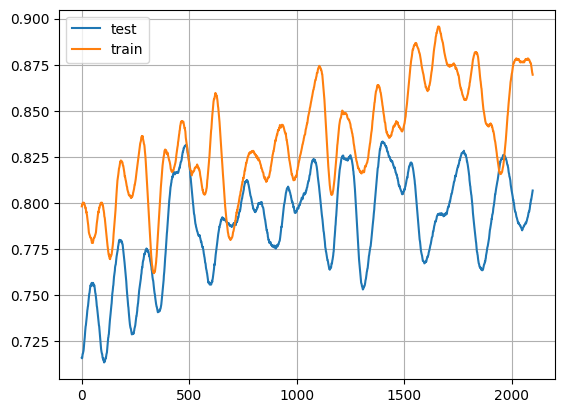

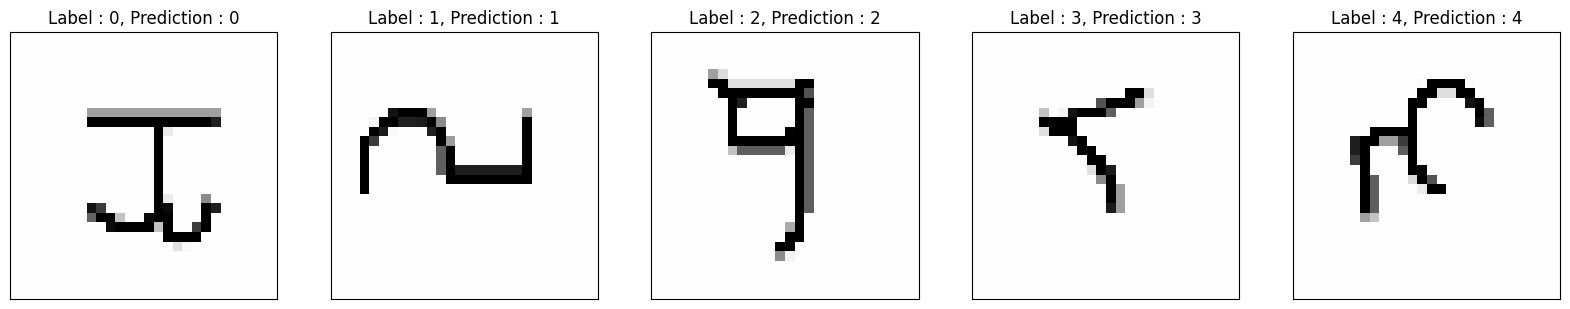

In [12]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1],
    training,
    training[-1:-window_length:-1],
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [13]:
tf.__version__

'2.15.0'

In [14]:
keras.__version__

'3.12.0'

In [15]:
import numpy
numpy.__version__

'1.26.4'